In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os
import augmentation
import matplotlib.pyplot as plt

In [10]:
class PatchDataset(Dataset):
    def __init__(self, hr_dir, if_translation=True, if_rotation=True, if_flip=True, if_downsample=True, flip_prob=0.5, tgt_patch_size=(48, 48, 48), curr_patch_size=(64, 64, 64)):
        self.hr_dir = hr_dir
        # store full patch paths
        self.hr_paths = []
        # store corresponding image names
        self.hr_img_names = []

        for image_folder in os.listdir(hr_dir):
            image_path = os.path.join(hr_dir, image_folder)

            # Ensure it's a directory
            if os.path.isdir(image_path):
                for patch in os.listdir(image_path):
                    patch_path = os.path.join(image_path, patch)

                    if os.path.isfile(patch_path):
                        self.hr_paths.append(patch_path)
                        self.hr_img_names.append(image_folder)
        
        # augmentation args
        self.translation = if_translation
        self.rotation = if_rotation
        self.flip = if_flip
        self.downsample = if_downsample
        self.flip_prob = flip_prob
        self.tgt_patch_size = tgt_patch_size
        self.curr_patch_size = curr_patch_size

    def __len__(self):
        return len(self.hr_paths)

    def augment(self, hr_patch):
        aug_patch = hr_patch
        if self.translation:
            aug_patch = augmentation.translation(aug_patch, self.tgt_patch_size, self.curr_patch_size)
        if self.rotation:
            aug_patch = augmentation.rotation(aug_patch)
        if self.flip:
            aug_patch = augmentation.flip(aug_patch, self.flip_prob)
        if self.downsample:
            aug_patch = augmentation.downsample(aug_patch)
        return aug_patch

    def __getitem__(self, index):
        hr_patch = np.load(self.hr_paths[index])
        aug_patch = self.augment(hr_patch)
        
        return torch.tensor(hr_patch, dtype = torch.float32), torch.tensor(aug_patch, dtype = torch.float32)



## Test

In [12]:
import tempfile

In [13]:
temp_dir = tempfile.mkdtemp()  # Temporary root directory (hr_dir)

# Number of image folders
num_image_folders = 3  # e.g., image_1, image_2, image_3
num_files_per_folder = 5  # 5 random 3D patches per image folder

# Create subdirectories and generate random 3D patches
for img_idx in range(num_image_folders):
    image_folder = os.path.join(temp_dir, f"image_{img_idx}")
    os.makedirs(image_folder, exist_ok=True)  # Create image folder

    for file_idx in range(num_files_per_folder):
        random_patch = np.random.rand(64, 64, 64)  # Random 3D patch
        file_path = os.path.join(image_folder, f"patch_{file_idx}.npy")  # Save inside image folder
        np.save(file_path, random_patch)

print(f"Temporary directory created at: {temp_dir}")
print("Random .npy files saved inside image folders.")


Temporary directory created at: /var/folders/4b/fz80g1lx73dc2924jgrz94gr0000gn/T/tmpf77y7i3s
Random .npy files saved inside image folders.


In [18]:
directory = temp_dir
print(directory)
test_dataset = PatchDataset(hr_dir = directory)

/var/folders/4b/fz80g1lx73dc2924jgrz94gr0000gn/T/tmpf77y7i3s


In [15]:
print("Dataset length:", len(test_dataset))

Dataset length: 15


In [16]:
sample_hr, sample_lr = test_dataset[1]  
# sometimes lead to error: 
# Certain augmentations (like flipping an array with [::-1] in NumPy) effectively create a view of the original array with reversed memory order.
# Also difference in shape of HR and LR patches???
print("Sample HR shape:", sample_hr.shape)
print("Sample LR shape:", sample_lr.shape)

chosen_axis:  (0, 1)
scale:  5
Sample HR shape: torch.Size([64, 64, 64])
Sample LR shape: torch.Size([50, 50, 50])


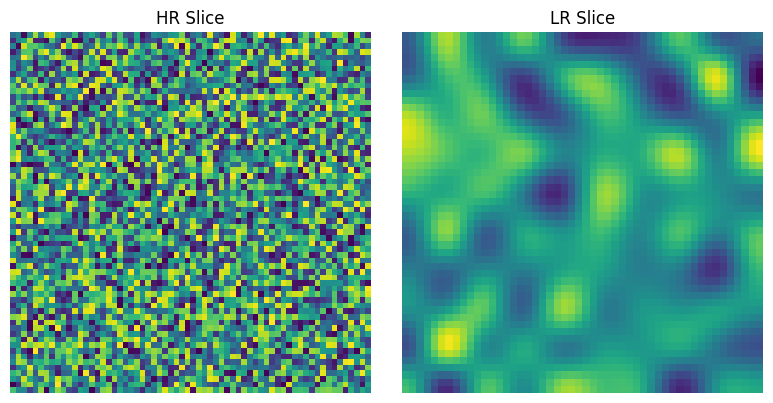

In [17]:
# Convert PyTorch tensors to NumPy arrays
hr_np = sample_hr.numpy()
lr_np = sample_lr.numpy()

# Determine how to slice the 3D volume ([D, H, W])
# Pick the middle slice along the depth dimension
d_hr = hr_np.shape[0] // 2
d_lr = lr_np.shape[0] // 2

# Extract that 2D slice
hr_slice = hr_np[d_hr, :, :]
lr_slice = lr_np[d_lr, :, :]

# Plot the two slices side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(hr_slice)
axes[0].set_title('HR Slice')
axes[0].axis('off')

axes[1].imshow(lr_slice)
axes[1].set_title('LR Slice')
axes[1].axis('off')

plt.tight_layout()
plt.show()
